<a href="https://colab.research.google.com/github/Smarth2005/A2-Sampling/blob/main/Sampling_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sampling Assignment Solution

In [10]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.metrics         import accuracy_score
from imblearn.over_sampling  import RandomOverSampler
from collections             import Counter

### Loading the Dataset

In [11]:
url = "https://raw.githubusercontent.com/AnjulaMehto/Sampling_Assignment/main/Creditcard_data.csv"
try:
    data = pd.read_csv(url)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

Dataset loaded successfully.


In [12]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Checking the Original Class Distribution

Original Class Distribution: Counter({0: 763, 1: 9})


Text(0.5, 1.0, 'Original Class Distribution')

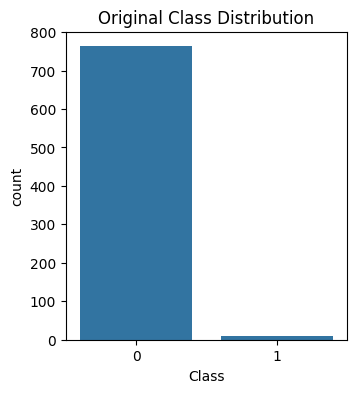

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

X = data.drop('Class', axis=1)
y = data['Class']

# Check original distribution
print(f"Original Class Distribution: {Counter(y)}")

# Plot Original Class Distribution
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=y, data=data)
plt.title("Original Class Distribution")

As observed, the "Class" distribution is highly imbalanced.

### Balancing the Class Dataset

Balanced Class Distribution: Counter({0: 763, 1: 763})


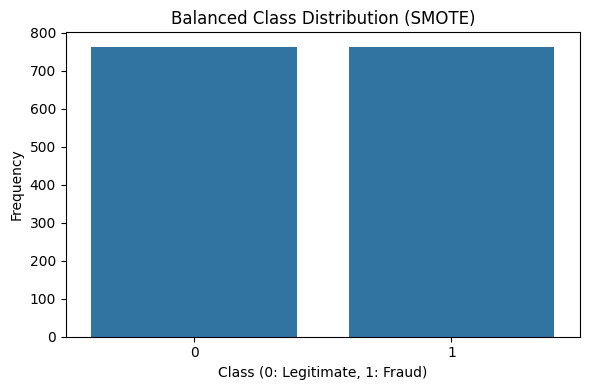

In [14]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Reconstruct the DataFrame
# SMOTE returns values, so we rebuild the DataFrame to keep column names
balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
balanced_df['Class'] = y_resampled

# Print Distribution
print(f"Balanced Class Distribution: {Counter(y_resampled)}")

# Plot Balanced Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=balanced_df)
plt.title("Balanced Class Distribution (SMOTE)")
plt.xlabel("Class (0: Legitimate, 1: Fraud)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Sample Size Calculation using Cochran's Formula:

$$n = \frac{Z^2 p (1-p)}{e^2}$$

**Parameters used:**
* Confidence Level: 95% ($Z = 1.96$)
* Estimated Proportion ($p$): 0.5 (Maximum variability)
* Margin of Error ($e$): 5% i.e., 0.05

$$n = \frac{(1.96)^2 \times 0.5 \times (1 - 0.5)}{(0.05)^2} \approx 385$$

In [15]:
# Define Sample Size formula (Cochran's Formula)
Z = 1.96
p = 0.5
E = 0.05
sample_size = math.ceil((Z**2 * p * (1-p)) / (E**2))
print(f"Calculated Sample Size: {sample_size}")

Calculated Sample Size: 385


### Applying different Sampling Techniques and Model Training

In [17]:
# Sampling Functions
def simple_random_sampling(df, n):
    return df.sample(n=n, random_state=42)

def stratified_sampling(df, n):
    # Stratified by Class
    return df.groupby('Class', group_keys=False).apply(lambda x: x.sample(min(len(x), int(n/2)), random_state=42))

def systematic_sampling(df, n):
    step = len(df) // n
    indices = np.arange(0, len(df), step)[:n]
    return df.iloc[indices]

def cluster_sampling(df, n):
    # Simulating clusters by grouping logic (e.g., dividing data into k clusters)
    k = 20 # Number of clusters
    df_copy = df.copy()
    df_copy['cluster'] = np.repeat(np.arange(k), len(df) // k + 1)[:len(df)]

    # Pick random clusters to satisfy sample size roughly
    clusters_needed = math.ceil(n / (len(df) // k))
    selected_clusters = np.random.choice(range(k), clusters_needed, replace=False)
    sample = df_copy[df_copy['cluster'].isin(selected_clusters)]
    return sample.drop('cluster', axis=1).iloc[:n] # Trim to size

def bootstrap_sampling(df, n):
    # Sampling with replacement
    return df.sample(n=n, replace=True, random_state=42)

# Dictionary of Sampling Techniques
sampling_techniques = {
    "Simple Random": simple_random_sampling,
    "Stratified": stratified_sampling,
    "Systematic": systematic_sampling,
    "Cluster": cluster_sampling,
    "Bootstrap": bootstrap_sampling
}

# Dictionary of Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsClassifier()
}

# Prepare results table
results = {model_name: {} for model_name in models.keys()}

# Train and Evaluate
# NOTE: We sample from the balanced dataset to train, and we can test on the remaining data or a fixed test set.
# For simplicity and comparison, we split the balanced data into Train/Test first,
# then apply sampling on the Training portion.

X_train_full, X_test, y_train_full, y_test = train_test_split(
    balanced_df.drop('Class', axis=1),
    balanced_df['Class'],
    test_size=0.2,
    random_state=42
)
train_df = pd.concat([X_train_full, y_train_full], axis=1)

for tech_name, sampler in sampling_techniques.items():
    # Generate sample from training data
    # Ensure sample size is not larger than available data
    n = min(sample_size, len(train_df))
    sample_df = sampler(train_df, n)

    X_sample = sample_df.drop('Class', axis=1)
    y_sample = sample_df['Class']

    for model_name, model in models.items():
        # Train model on the sample
        model.fit(X_sample, y_sample)
        # Predict on the held-out test set
        y_pred = model.predict(X_test)
        # Calculate accuracy
        acc = accuracy_score(y_test, y_pred)
        results[model_name][tech_name] = round(acc * 100, 2)


/tmp/ipython-input-3450629149.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('Class', group_keys=False).apply(lambda x: x.sample(min(len(x), int(n/2)), random_state=42))
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Results

In [18]:
# Determine which technique gives higher accuracy
results_df = pd.DataFrame(results).T # Transpose to match the assignment image format
print("\n--- Accuracy Results (%) ---")
print(results_df)

# Find the best combination
best_acc = 0
best_model = ""
best_sampler = ""

for model in results_df.index:
    for sampler in results_df.columns:
        if results_df.loc[model, sampler] > best_acc:
            best_acc = results_df.loc[model, sampler]
            best_model = model
            best_sampler = sampler

print(f"\nHighest Accuracy: {best_acc}%")
print(f"Best Model: {best_model}")
print(f"Best Sampling Technique: {best_sampler}")


--- Accuracy Results (%) ---
                     Simple Random  Stratified  Systematic  Cluster  Bootstrap
Logistic Regression          90.52       90.52       92.16    90.85      91.50
Decision Tree                94.44       93.14       95.42    94.44      94.44
Random Forest                99.02       99.02       98.37    99.02      98.04
SVM                          66.67       64.71       66.01    67.32      66.01
KNN                          79.08       74.18       80.07    77.78      78.43

Highest Accuracy: 99.02%
Best Model: Random Forest
Best Sampling Technique: Simple Random


### Saving Results to CSV

In [19]:
results_df.to_csv("sampling_results.csv")
print("\nResults saved to 'sampling_results.csv'")


Results saved to 'sampling_results.csv'
